In [1]:
import os
import logging
import numpy as np

from scipy.spatial.transform import Rotation as R
from torchvision.transforms import ToTensor
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

from PIL import Image
from pathlib import Path
from tqdm import tqdm
import json

import sys
import os

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [3]:
renders_path = Path('/mnt/ML/Datasets/shapenet renders/renders_pyrender')
renders_path = Path('renders_360_2')

In [5]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/autoencoder')

In [ ]:
from renders_data import load_metadatas, load_render, BackgroundColor, NormTorchToPil, RenderDataset, makeDataLoader

In [ ]:
def get_preprocessor(size):
    return transforms.Compose([
        transforms.Resize(size),
        BackgroundColor((0.5, 0.5, 0.5)),
        transforms.Normalize([0.5], [0.5])
    ])

In [9]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 500
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 1
    save_model_epochs = 10
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = 'ddim-cars-360_128_2'  # the model namy locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_private_repo = False  
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

In [15]:
data_transforms = get_preprocessor((config.image_size, config.image_size))
data_augmentations = None #RandomHue()
data = load_metadatas(renders_path)
train_loader, valid_loader, train_size, val_size = makeDataLoader(data, config, RenderDataset, data_transforms, data_augmentations)

In [48]:
from diffusers import UNet2DModel

def load_model(path):
    model = UNet2DModel.from_pretrained(path).cuda()
    return model

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D", 
        "DownBlock2D", 
        "AttnDownBlock2D", 
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "AttnUpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D"  
      ),
)

#model = load_model('ddim-cars-360_128/unet')

In [17]:
from diffusers import DDIMScheduler

noise_scheduler = DDIMScheduler(num_train_timesteps=1000)

In [18]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

In [19]:
from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(train_size * config.num_epochs),
)

In [ ]:
from ddim import denoise_image

In [194]:
def process_png(path, data_transforms, config):
    image = Image.open(path)
    image = transforms.ToTensor()(image)
    image = data_transforms(image)
    return image

In [195]:
def repaint(frac, num_steps):
    image = process_png('seed.png', data_transforms, config).cuda()
    images = image.unsqueeze(0)
    on, r = denoise_image(model, noise_scheduler, images, frac, num_steps)
    img = r[0]
    display(transforms.ToPILImage()(0.5*image+0.5))
    display(transforms.ToPILImage()(0.5*on[0]+0.5))
    display(transforms.ToPILImage()(0.5*img+0.5))

  0%|          | 0/1 [00:00<?, ?it/s]

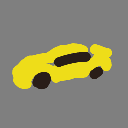

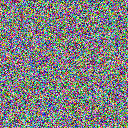

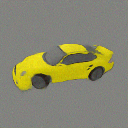

In [242]:
repaint(0.5, 1)

In [23]:
from diffusers import DDIMPipeline

import math

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline, num_inference_steps=200):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size = config.eval_batch_size, 
        generator=torch.manual_seed(config.seed),
        num_inference_steps=num_inference_steps,
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [24]:
from accelerate import Accelerator

from tqdm.auto import tqdm
import os

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 
        log_with="tensorboard",
        logging_dir=os.path.join(config.output_dir, "logs")
    )
    if accelerator.is_main_process:
        accelerator.init_trackers("train_example")
    
    # Prepare everything
    # There is no specific order to remember, you just need to unpack the 
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    
    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
            
            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDIMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    push_to_hub(config, pipeline, repo, commit_message=f"Epoch {epoch}", blocking=True)
                else:
                    pipeline.save_pretrained(config.output_dir) 

In [25]:
from accelerate import notebook_launcher
args = (config, model, noise_scheduler, optimizer, train_loader, lr_scheduler)

#notebook_launcher(train_loop, args, num_processes=0)

In [26]:
accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 
        log_with="tensorboard",
        logging_dir=os.path.join(config.output_dir, "logs")
)

pipeline = DDIMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
config.seed = 1
evaluate(config, 81, pipeline)
config.seed = 0

  0%|          | 0/200 [00:00<?, ?it/s]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!